In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def map_signed_number(n):
    """
    Maps signed integers to non-negative integers using the formula:
    2|n| for n >= 0
    2|n|-1 for n < 0
    """
    if n >= 0:
        return 2 * n
    else:
        return 2 * abs(n) - 1

def inverse_map_signed_number(mapped_n):
    """
    Converts the mapped non-negative integer back to signed integer.
    """
    if mapped_n % 2 == 0:  # Even numbers map to non-negative
        return mapped_n // 2
    else:  # Odd numbers map to negative
        return -(mapped_n + 1) // 2

def golomb_encode(n, m):
    """
    Golomb encode a non-negative number n with parameter m.
    Returns the code and its length.
    """
    q = n // m
    r = n % m

    # Unary code for quotient
    unary = '0' * q + '1'

    # Truncated binary code for remainder
    c = int(np.ceil(np.log2(m)))
    k = 2**c - m

    if r < k:
        remainder = format(r, f'0{c-1}b')
    else:
        remainder = format(r + k, f'0{c}b')

    return unary + remainder, len(unary + remainder)

def analyze_image_differences(image_path):
    """
    Analyze pixel differences in an image and demonstrate Golomb coding.
    """
    # Read and convert image to grayscale
    img = np.array(Image.open(image_path).convert('L'))

    # Calculate horizontal differences
    diff_horizontal = np.diff(img, axis=1)

    # Calculate probability distribution of differences
    unique_diffs, counts = np.unique(diff_horizontal, return_counts=True)
    prob_diffs = counts / counts.sum()

    # Map differences to non-negative integers
    mapped_diffs = np.array([map_signed_number(d) for d in diff_horizontal.flatten()])

    # Estimate p for geometric distribution
    # Using mean of mapped differences to estimate p
    mean_mapped = np.mean(mapped_diffs)
    p_estimate = 1 / (mean_mapped + 1)

    # Calculate optimal m
    optimal_m = int(round(np.log2(1 + p_estimate) / np.log2(1/p_estimate)))

    # Create visualizations
    plt.figure(figsize=(15, 12))

    # Original image
    plt.subplot(2, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Difference image
    plt.subplot(2, 2, 2)
    plt.imshow(diff_horizontal, cmap='gray')
    plt.title('Horizontal Differences')
    plt.axis('off')

    # Distribution of original differences
    plt.subplot(2, 2, 3)
    plt.hist(diff_horizontal.flatten(), bins=50, density=True)
    plt.title('Distribution of Differences')
    plt.xlabel('Difference Value')
    plt.ylabel('Frequency')

    # Distribution of mapped differences
    plt.subplot(2, 2, 4)
    plt.hist(mapped_diffs, bins=50, density=True)
    plt.title('Distribution of Mapped Differences')
    plt.xlabel('Mapped Difference Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Encode some example differences
    print("\nExample Golomb Coding of Differences:")
    print(f"Estimated p: {p_estimate:.3f}")
    print(f"Optimal m: {optimal_m}")
    print("\nExample encodings (first few differences):")
    print(f"{'Original':>10} | {'Mapped':>8} | {'Code':>15} | {'Length':>6}")
    print("-" * 50)

    # Show first few encodings
    for orig_diff in diff_horizontal[0, :10]:
        mapped = map_signed_number(orig_diff)
        code, length = golomb_encode(mapped, optimal_m)
        print(f"{orig_diff:10d} | {mapped:8d} | {code:15s} | {length:6d}")

    return diff_horizontal, mapped_diffs, optimal_m

# Function to calculate entropy of differences
def calculate_entropy(data):
    """Calculate entropy of the data in bits."""
    unique, counts = np.unique(data, return_counts=True)
    probabilities = counts / len(data)
    return -np.sum(probabilities * np.log2(probabilities))


Analysis for uniform image:
Entropy of differences: -0.00 bits
Estimated p: 0.999
Optimal Golomb parameter m: 692

Example encodings for first few unique differences:
Difference |   Mapped | Optimal m
----------------------------------------
         0 |        0 |      692

Analysis for gradient image:
Entropy of differences: -0.00 bits
Estimated p: 0.333
Optimal Golomb parameter m: 0

Example encodings for first few unique differences:
Difference |   Mapped | Optimal m
----------------------------------------
         1 |        2 |        0

Analysis for checkerboard image:
Entropy of differences: 0.21 bits
Estimated p: 0.125
Optimal Golomb parameter m: 0

Example encodings for first few unique differences:
Difference |   Mapped | Optimal m
----------------------------------------
         0 |        0 |        0
         1 |        2 |        0
       255 |      510 |        0

Analysis for noise image:
Entropy of differences: 8.00 bits
Estimated p: 0.004
Optimal Golomb parameter 

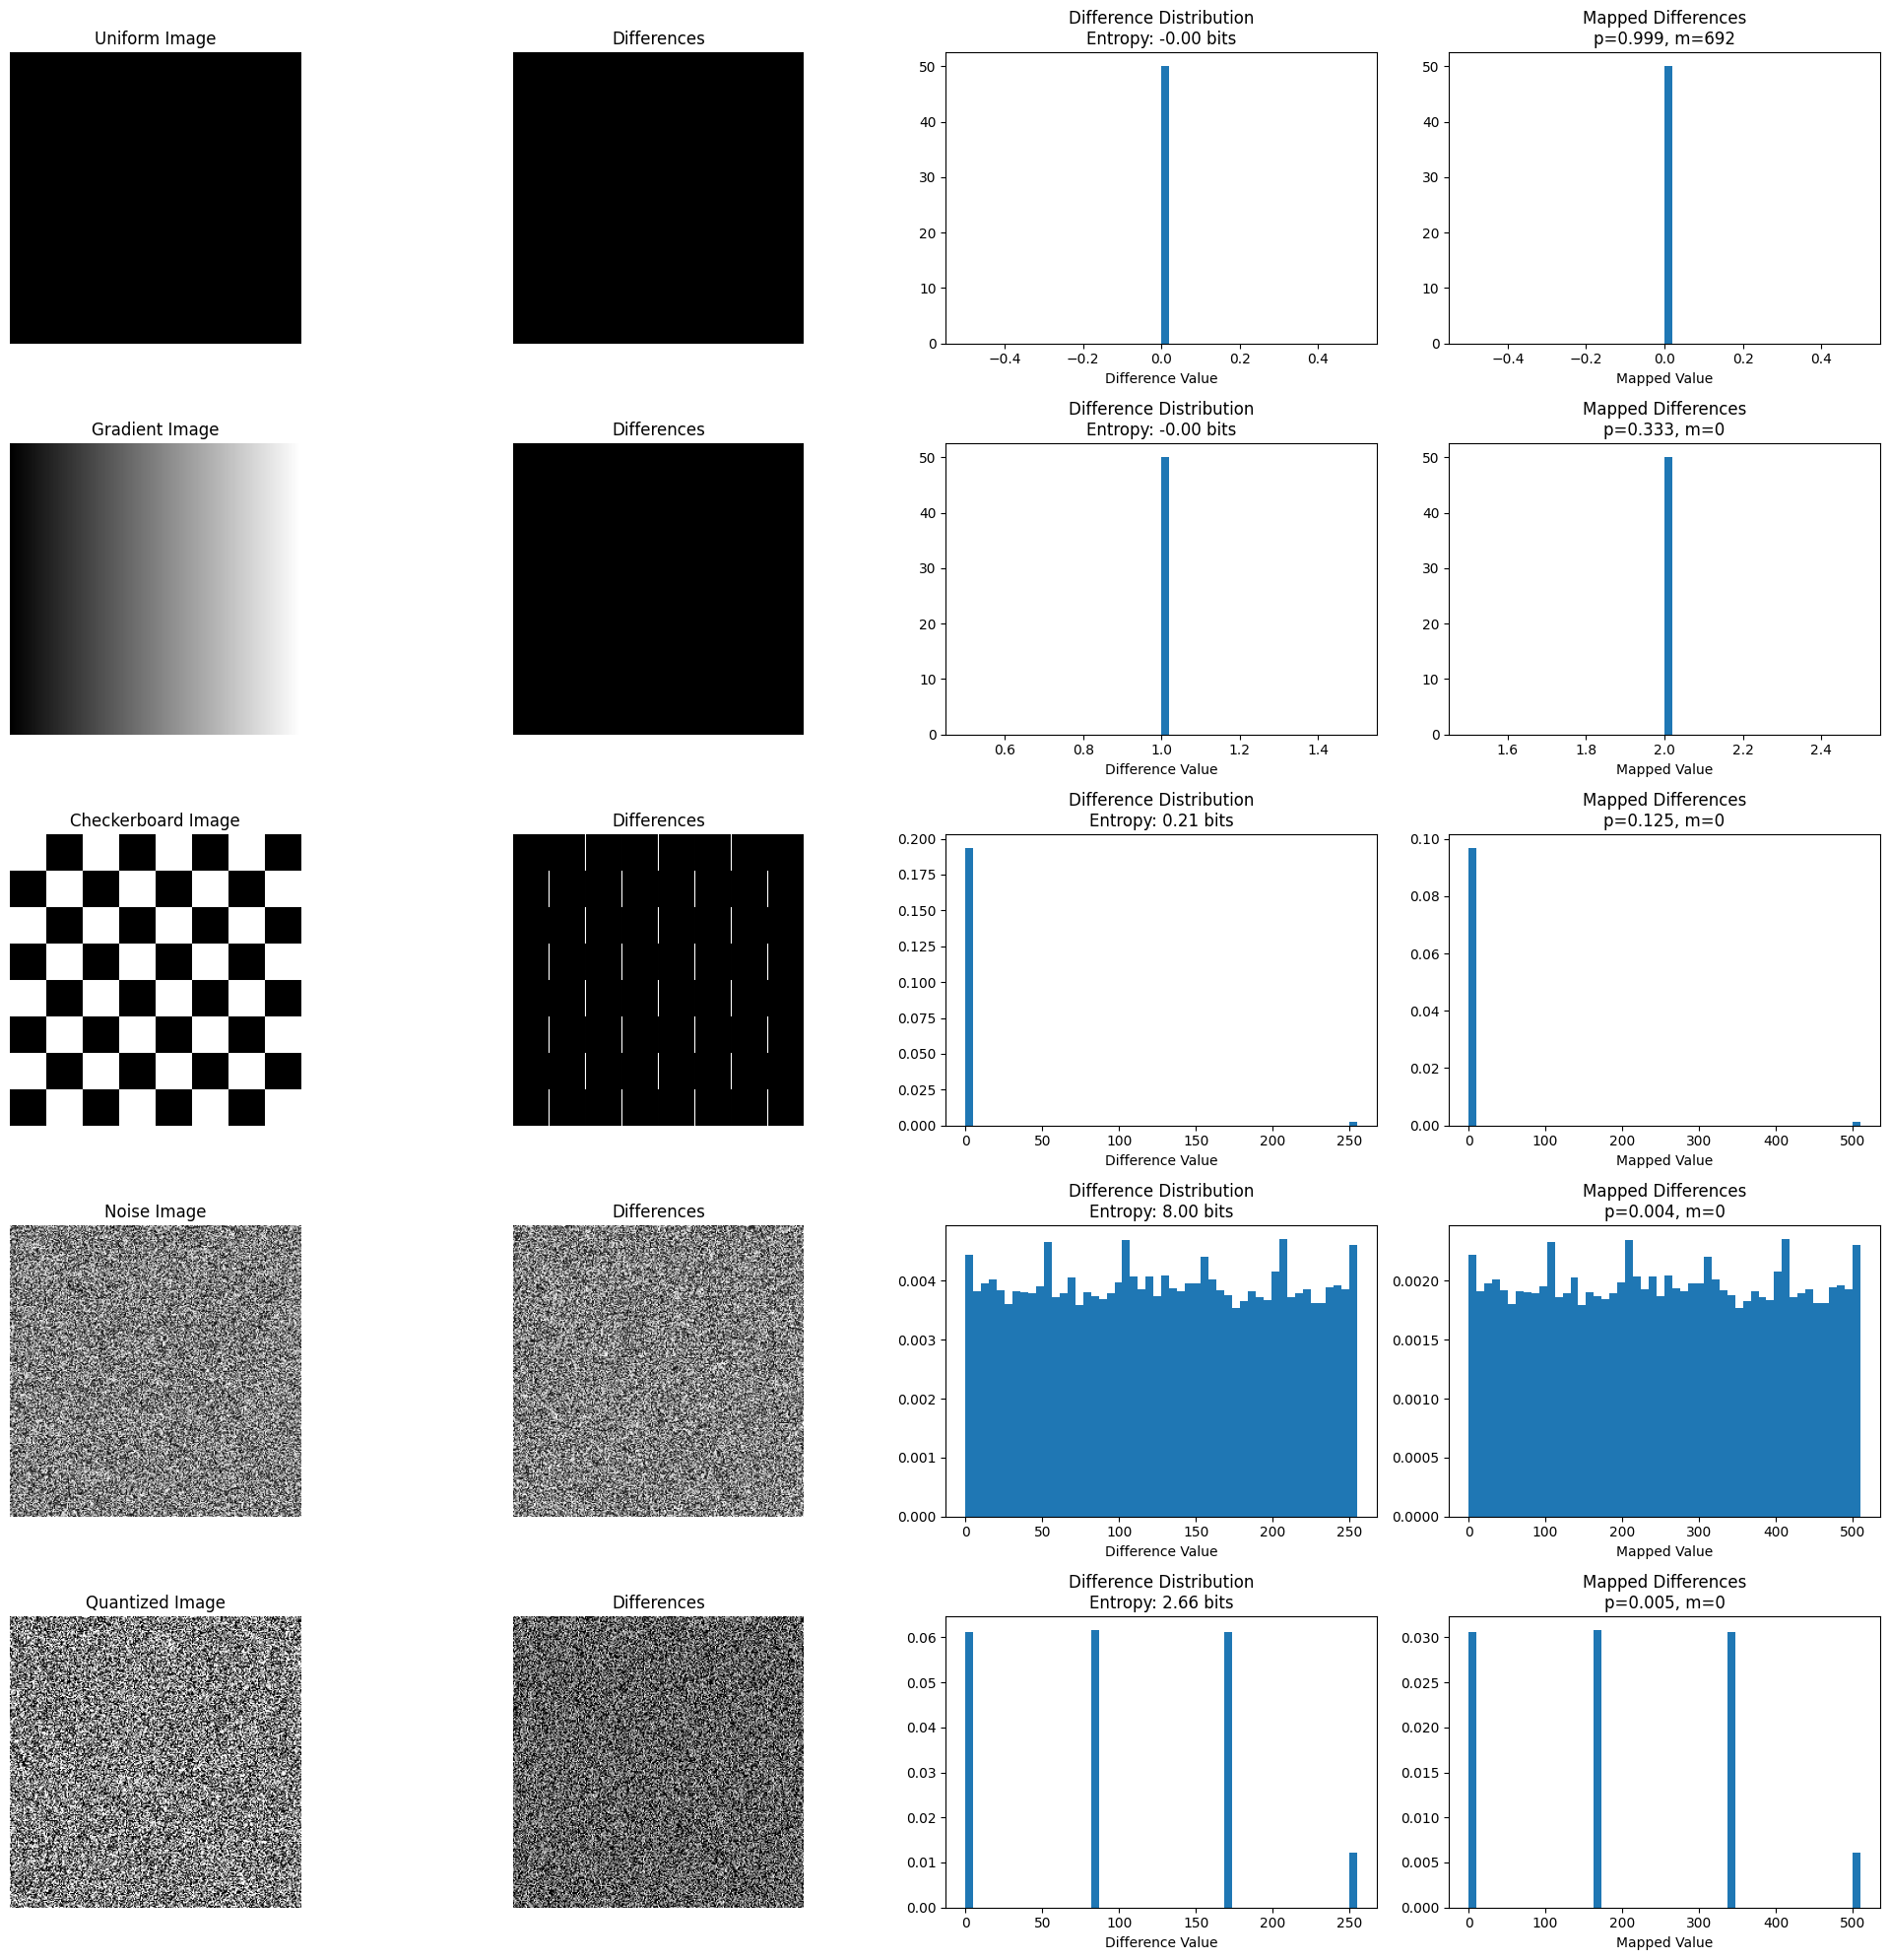

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def create_test_images(size=(256, 256)):
    """Creates our set of test images with different characteristics."""
    images = {}

    # Uniform image (should have zero differences)
    images['uniform'] = np.ones(size, dtype=np.uint8) * 128

    # Horizontal gradient (constant differences)
    gradient_h = np.linspace(0, 255, size[1], dtype=np.uint8)
    images['gradient'] = np.tile(gradient_h, (size[0], 1))

    # Checkerboard (alternating large differences)
    checkerboard = np.zeros(size, dtype=np.uint8)
    tile_size = 32
    for i in range(0, size[0], tile_size):
        for j in range(0, size[1], tile_size):
            if (i//tile_size + j//tile_size) % 2 == 0:
                checkerboard[i:i+tile_size, j:j+tile_size] = 255
    images['checkerboard'] = checkerboard

    # Random noise (large random differences)
    images['noise'] = np.random.randint(0, 256, size=size, dtype=np.uint8)

    # Quantized image (few unique differences)
    levels = 4
    quantized = np.linspace(0, 255, levels, dtype=np.uint8)
    random_indices = np.random.randint(0, levels, size=size)
    images['quantized'] = quantized[random_indices]

    return images

def map_signed_number(n):
    """Maps signed integers to non-negative integers using the formula:
    2|n| for n >= 0
    2|n|-1 for n < 0"""
    return 2 * n if n >= 0 else 2 * abs(n) - 1

def analyze_image_differences(image, title):
    """Analyzes the differences in an image and their distribution."""
    # Calculate horizontal differences
    diff_horizontal = np.diff(image, axis=1)

    # Map differences to non-negative integers
    mapped_diffs = np.array([map_signed_number(d) for d in diff_horizontal.flatten()])

    # Estimate p for geometric distribution
    mean_mapped = np.mean(mapped_diffs)
    p_estimate = 1 / (mean_mapped + 1) if mean_mapped > 0 else 0.999

    # Calculate optimal m
    optimal_m = int(round(np.log2(1 + p_estimate) / np.log2(1/p_estimate)))

    # Calculate entropy
    unique, counts = np.unique(diff_horizontal, return_counts=True)
    probabilities = counts / len(diff_horizontal.flatten())
    entropy = -np.sum(probabilities * np.log2(probabilities))

    return {
        'differences': diff_horizontal,
        'mapped_differences': mapped_diffs,
        'p_estimate': p_estimate,
        'optimal_m': optimal_m,
        'entropy': entropy
    }

def visualize_difference_analysis(images):
    """Creates comprehensive visualizations for each test image."""
    n_images = len(images)
    plt.figure(figsize=(20, 4*n_images))

    for idx, (name, img) in enumerate(images.items()):
        # Analyze image
        analysis = analyze_image_differences(img, name)

        # Original image
        plt.subplot(n_images, 4, 4*idx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{name.capitalize()} Image')
        plt.axis('off')

        # Difference image
        plt.subplot(n_images, 4, 4*idx + 2)
        plt.imshow(analysis['differences'], cmap='gray')
        plt.title('Differences')
        plt.axis('off')

        # Original difference distribution
        plt.subplot(n_images, 4, 4*idx + 3)
        plt.hist(analysis['differences'].flatten(), bins=50, density=True)
        plt.title(f'Difference Distribution\nEntropy: {analysis["entropy"]:.2f} bits')
        plt.xlabel('Difference Value')

        # Mapped difference distribution
        plt.subplot(n_images, 4, 4*idx + 4)
        plt.hist(analysis['mapped_differences'], bins=50, density=True)
        plt.title(f'Mapped Differences\np={analysis["p_estimate"]:.3f}, m={analysis["optimal_m"]}')
        plt.xlabel('Mapped Value')

        # Print analysis
        print(f"\nAnalysis for {name} image:")
        print(f"Entropy of differences: {analysis['entropy']:.2f} bits")
        print(f"Estimated p: {analysis['p_estimate']:.3f}")
        print(f"Optimal Golomb parameter m: {analysis['optimal_m']}")

        # Show example encodings for first few differences
        unique_diffs = np.unique(analysis['differences'])[:5]
        print("\nExample encodings for first few unique differences:")
        print(f"{'Difference':>10} | {'Mapped':>8} | {'Optimal m':>8}")
        print("-" * 40)
        for diff in unique_diffs:
            mapped = map_signed_number(diff)
            print(f"{diff:10d} | {mapped:8d} | {analysis['optimal_m']:8d}")

    plt.tight_layout()
    plt.show()

# Generate and analyze test images
test_images = create_test_images()
visualize_difference_analysis(test_images)

In [ ]:
# Load and analyze an image
differences, mapped_diffs, optimal_m = analyze_image_differences('your_image.png')

# Calculate and print entropy comparison
original_entropy = calculate_entropy(differences)
mapped_entropy = calculate_entropy(mapped_diffs)

print(f"\nEntropy Analysis:")
print(f"Original differences entropy: {original_entropy:.2f} bits/symbol")
print(f"Mapped differences entropy: {mapped_entropy:.2f} bits/symbol")